In [187]:
import pandas as pd
import numpy as np
import functions as f
from sklearn import linear_model

import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_style('darkgrid')

# make sure that in your repo, there is a symlink (named 'data') to the real 'data' folder
def data_loc(filename):
    import os
    return os.path.join(os.readlink('data'), filename)

# if you make changes to functions.py, use this before running anything:
reload(f)

<module 'functions' from 'functions.pyc'>

# Import and preprocess court data

In [188]:
# choose cols to import. goes very slowly if you try to import everything, and some cols make it error. see file
# import_cols = ['attend', 'racdin', 'racmar', 'year']

# chunksize must be None or >= 57061 rows (for GSS), because of pandas flaw
aff_ac = f.load_dta(data_loc('Circuit Cases/affirmative_action_panel_level.dta'), chunksize = None)
race_discr = f.load_dta(data_loc('Circuit Cases/race_discrimination_panel_level.dta'), chunksize = None)

aff_ac['casetype'] = "aff_ac"
race_discr['casetype'] = "race_discr"

# join the two datasets, convert the date
joint = pd.concat([aff_ac, race_discr]) 
joint['date'] = pd.to_datetime(joint.year.astype(int)*10000 + joint.month.astype(int)*100 + np.random.randint(1, 29, size = len(joint)), format='%Y%m%d')

Loaded 153 rows...
Done!
Loaded 308 rows...
Done!


In [189]:
joint = joint[["circuit", "year", "panelvote", "casetype"]]
joint.year = joint.year.astype(int)

In [190]:
joint['votelib'] = joint['panelvote']
joint['votecons'] = 3 - joint['panelvote']
joint['votenorm'] = 1.5 - joint['panelvote']

In [191]:
groupby_type = joint.groupby('casetype')

In [192]:
groupby_year_type = joint.groupby(['casetype', 'year'])
groupby_year_type = groupby_year_type.votenorm.aggregate(np.sum).reset_index()
# lets just take affirmative action cases for now
affirm_year = groupby_year_type[groupby_year_type['casetype']=='aff_ac'].set_index('year')


In [193]:
years = []
lags = []
casesums = []
for y in range(1985, 2005):
    for l in range(1, 6):
        years.append(y)
        lags.append(l)
        casesums.append(affirm_year.at[y-l, 'votenorm'])

In [194]:
affirm_5yr = pd.DataFrame({'year': years, 'lag': lags, 'casesum': casesums})

In [195]:
affirm_5yr = affirm_5yr.set_index(['year', 'lag'])

# Import and preprocess GSS data

In [219]:
# choose cols to import. goes very slowly if you try to import everything, and some cols make it error. see file
import_cols = ['id', 'affrmact', 'year', 'age', 'sex', 'race', 'region', 'educ', 'relig']
# import_cols = ['racdin', 'year', 'age', 'sex']
# these seem like all of the relevant categories. Some of them don't plot nicely yet.



# chunksize must be None or >= 57061 rows (for GSS), because of pandas flaw
gss = f.load_dta(data_loc('GSS7212_R2.DTA'), chunksize = None,
                 columns = import_cols)


gss = f.preprocess_gss_demographics(gss)

prej = pd.read_csv("composites/prejudiceVar.csv")
gss = gss.merge(prej, 'left', on=["year","id"])

Loaded 57061 rows...
Done!


In [197]:
gss.affrmact.unique()

[NaN, strongly support pref, strongly oppose pref, support pref, oppose pref]
Categories (4, object): [strongly support pref < support pref < oppose pref < strongly oppose pref]

In [198]:
# drop all rows where y variable is NA
gss = gss[gss['affrmact'].notnull()]
# change racdin to numeric
gss.affrmact = gss.affrmact.map({'strongly support pref': 1.5, 'support pref': .5,
                                 'oppose pref': -.5, 'strongly oppose pref': -1.5})
# drop years without court case history
gss = gss[(gss['year'] > 1984) & (gss['year'] < 2005)]
gss = gss.reset_index()
# add variables for last 5 years court cases
# this takes a few seconds...
for l in range(1, 6):
    gss['courtlag' + str(l)] = 0
for i in range(len(gss)):
    curr_year = gss.loc[i, 'year']
    for l in range(1, 6):
        gss.loc[i, 'courtlag' + str(l)] = affirm_5yr.loc[(curr_year, l), 'casesum'] 

In [199]:
# add interactions with time
columns = gss.columns.tolist()
for c in columns[4:]:
    gss[c + '_X_year'] = gss[c] * gss['year_norm']

In [200]:
gss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8398 entries, 0 to 8397
Data columns (total 70 columns):
index                                   8398 non-null int64
affrmact                                8398 non-null float64
year                                    8398 non-null int16
year_norm                               8398 non-null float64
age                                     8398 non-null int8
sex                                     8398 non-null int64
educ                                    8398 non-null float64
race_white                              8398 non-null float64
race_black                              8398 non-null float64
race_other                              8398 non-null float64
region_new england                      8398 non-null float64
region_middle atlantic                  8398 non-null float64
region_e. nor. central                  8398 non-null float64
region_w. nor. central                  8398 non-null float64
region_south atlantic             

In [214]:
# randomly split out 2000 test examples
gss = gss.iloc[np.random.permutation(len(gss))]
traindata = gss.values[0:(len(gss)-2000), 0:]
testdata = gss.values[(len(gss)-2000):, 0:]
print traindata.shape
print testdata.shape

(6398, 70)
(2000, 70)


In [215]:
regmodel = linear_model.Ridge()
regmodel.fit(traindata[0:, 3:], traindata[0:, 1])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [216]:
print regmodel.score(traindata[0:, 3:], traindata[0:, 1])
print regmodel.score(testdata[0:, 3:], testdata[0:, 1])

0.130968478212
0.128378828734


In [217]:
results = pd.DataFrame({'param': gss.columns.tolist()[3:],
                        'value': regmodel.coef_})

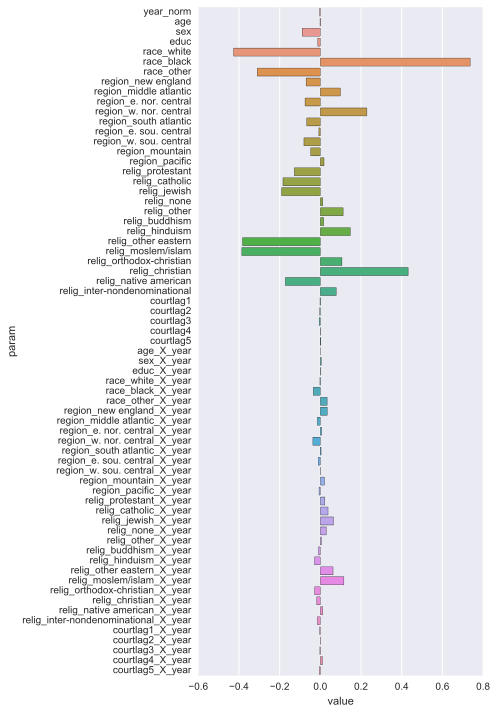

In [218]:
sns.factorplot('value', 'param', kind="bar", data=results, size=10, aspect=.7)